In [40]:
# import libraries we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall

## Datasets

In [16]:
# Load the dataset
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')
pd.set_option('display.max_columns', None)

## Data Pre-Processing

### Imblanced piecahrt

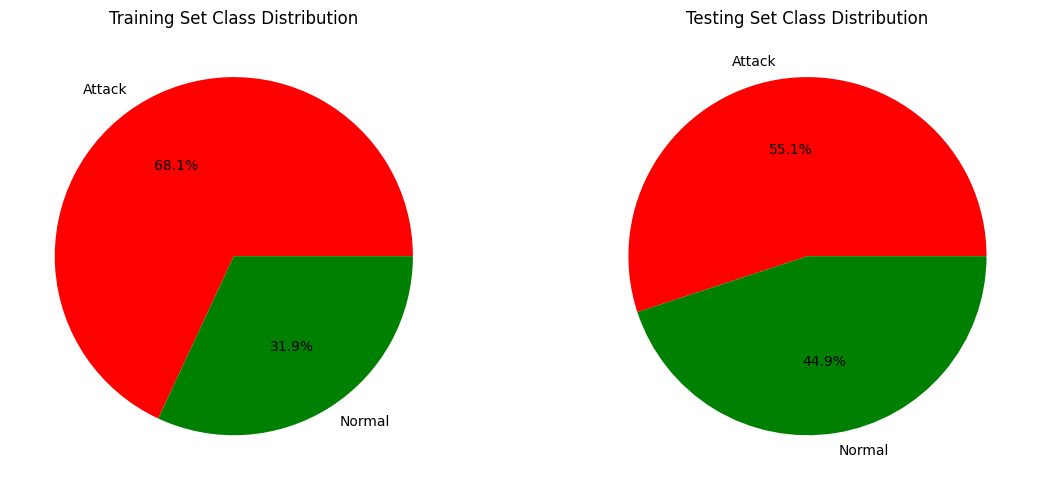

Training Set:
Total Samples: 175341
Normal Instances: 56000
Attack Instances: 119341

Testing Set:
Total Samples: 82332
Normal Instances: 37000
Attack Instances: 45332


In [17]:
# Count attacks and normal instances in training set
train_attack = len(df_train[df_train['label'] == 1])
train_normal = len(df_train[df_train['label'] == 0])

# Count attacks and normal instances in testing set
test_attack = len(df_test[df_test['label'] == 1])
test_normal = len(df_test[df_test['label'] == 0])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set pie chart
train_sizes = [train_attack, train_normal]
train_labels = ['Attack', 'Normal']
ax1.pie(train_sizes, labels=train_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax1.set_title('Training Set Class Distribution')

# Testing set pie chart
test_sizes = [test_attack, test_normal]
test_labels = ['Attack', 'Normal']
ax2.pie(test_sizes, labels=test_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax2.set_title('Testing Set Class Distribution')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print out the exact numbers for reference
print("Training Set:")
print(f"Total Samples: {len(df_train)}")
print(f"Normal Instances: {train_normal}")
print(f"Attack Instances: {train_attack}")

print("\nTesting Set:")
print(f"Total Samples: {len(df_test)}")
print(f"Normal Instances: {test_normal}")
print(f"Attack Instances: {test_attack}")

### NA Check

In [18]:
# NACheck
NACheck = df_train.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    175341.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [19]:
NACheck = df_test.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    82332.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

### Missing data:
There are **no missing values** in the dataset at all.
### Imbalanced data:
As we can see, the data we get is **seriously imbalanced**.

### Correlation Heatmap

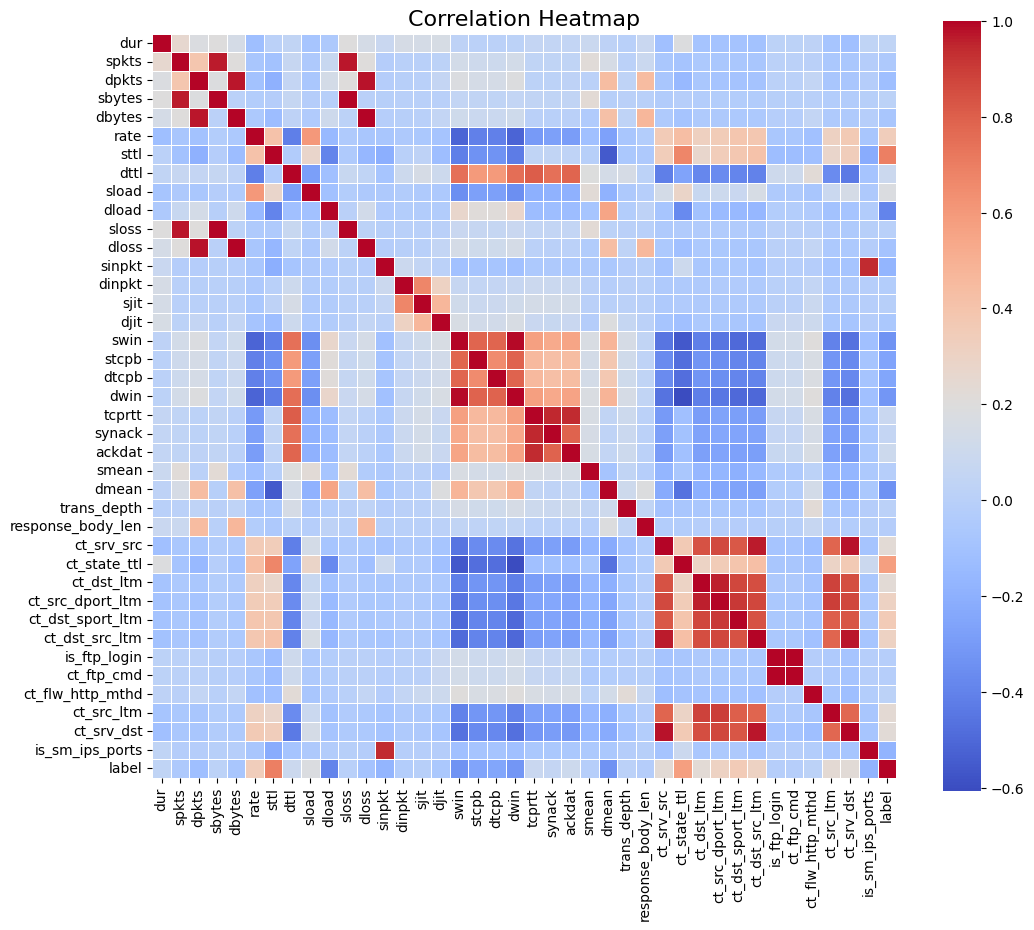

In [20]:
# Drop object/string columns
string_columns = df_train.select_dtypes(include=['object']).columns
df_train = df_train.drop(columns=string_columns)
df_train = df_train.drop('id', axis=1)
# Compute the correlation matrix
correlation_matrix = df_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

# Add title
plt.title("Correlation Heatmap", fontsize=16)

# Display the heatmap
plt.show()

### Feature Selection
Choose Which feature is useful for the Thread Detection using correlation and ANOVA

#### Correlation

In [21]:
# Compute Correlation with the target column 'label'
correlation = df_train.corrwith(df_train['label']).sort_values(ascending=False).to_frame()
correlation.columns = ['corr']  

# Select features with significant positive correlation (> 0.1)
PositiveCorrelation = correlation[correlation['corr'] > 0.1]

# Select features with significant negative correlation (< -0.1)
NegativeCorrelation = correlation[correlation['corr'] < -0.1]

# Combine positively and negatively correlated features
FeatureTemp = NegativeCorrelation.index.append(PositiveCorrelation.index)

# Create a subset of the DataFrame with these features
FilterSelectionColumn = df_train[FeatureTemp]  # Subset DataFrame with selected features
correlation

,corr
label,1.000000
sttl,0.692741
ct_state_ttl,0.577704
ct_dst_sport_ltm,0.357213
rate,0.337979
ct_src_dport_ltm,0.305579
ct_dst_src_ltm,0.303855
ct_src_ltm,0.238225
ct_dst_ltm,0.229887
ct_srv_src,0.229044


#### ANOVA

In [22]:
# Prepare features and target for ANOVA
features = df_train.drop('label', axis=1)  # Drop 'label' to isolate features
target = df_train['label']  # Target variable

# Use SelectKBest with ANOVA (f_classif) to score features
best_features = SelectKBest(score_func=f_classif, k='all')  # Evaluate all features
fit = best_features.fit(features, target)  # Fit the ANOVA model

# Store ANOVA scores in a DataFrame for easier interpretation
featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
featureScores

,ANOVA Score
dur,229.749327
spkts,478.672832
dpkts,2501.116244
sbytes,60.522430
dbytes,1042.259653
rate,22611.817828
sttl,161780.526952
dttl,1598.495322
sload,6066.435816
dload,32170.312851


#### Feature Selection
Select the features where both ANOVA and correlation significantly contribute to the classification process.

In [26]:
# Combine Correlation and ANOVA results
# Merge correlation and ANOVA scores into a single DataFrame
combined_scores = featureScores.merge(correlation, left_index=True, right_index=True)

# Filter features where both correlation and ANOVA score thresholds are satisfied
# (ANOVA Score > threshold, correlation > 0.1 or < -0.1)
anova_threshold = 2000  # Example threshold for ANOVA scores
selected_features = combined_scores[
    (combined_scores['corr'].abs() > 0.1) & (combined_scores['ANOVA Score'] > anova_threshold)
]

# Subset the original DataFrame with the selected features
final_selected_features = selected_features.index.tolist()  # Get the names of selected features
final_df = df_train[final_selected_features + ['label']]  # Include 'label' column for classification tasks

# Display the selected features and scores
print("Selected Features Based on Correlation and ANOVA:")
print(selected_features)

# Final filtered DataFrame for model training or evaluation
print("\nFinal DataFrame with Selected Features:")
final_df

Selected Features Based on Correlation and ANOVA:
                    ANOVA Score      corr
dpkts               2501.116244 -0.118591
rate               22611.817828  0.337979
sttl              161780.526952  0.692741
sload               6066.435816  0.182870
dload              32170.312851 -0.393739
sinpkt              5612.172675 -0.176110
swin               21961.796620 -0.333633
stcpb              12194.973688 -0.255006
dtcpb              11723.168274 -0.250340
dwin               19950.909669 -0.319626
dmean              23195.039749 -0.341806
ct_srv_src          9707.760648  0.229044
ct_state_ttl       87830.779493  0.577704
ct_dst_ltm          9783.377995  0.229887
ct_src_dport_ltm   18059.210546  0.305579
ct_dst_sport_ltm   25645.955324  0.357213
ct_dst_src_ltm     17835.399757  0.303855
ct_src_ltm         10549.386809  0.238225
ct_srv_dst          9618.746066  0.228046
is_sm_ips_ports     6191.368613 -0.184679

Final DataFrame with Selected Features:


,dpkts,rate,sttl,sload,dload,sinpkt,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,4,74.087490,252,1.415894e+04,8495.365234,24.295600,255,621772692,2202533631,255,43,1,0,1,1,1,1,1,1,0,0
1,38,78.473372,62,8.395112e+03,503571.312500,49.915000,255,1417884146,3077387971,255,1106,43,1,1,1,1,2,1,6,0,0
2,16,14.170161,62,1.572272e+03,60929.230470,231.875571,255,2116150707,2963114973,255,824,7,1,2,1,1,3,2,6,0,0
3,12,13.677108,62,2.740179e+03,3358.622070,152.876547,255,1107119177,1047442890,255,64,1,1,2,1,1,3,2,1,0,0
4,6,33.373826,254,8.561499e+03,3987.059814,47.750333,255,2436137549,1977154190,255,45,43,1,2,2,1,40,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,24,2,24,24,13,24,24,24,0,1
175337,8,33.612649,254,8.826286e+03,4903.492188,54.400111,255,3518776216,3453092386,255,44,1,1,1,1,1,2,1,1,0,1
175338,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,12,2,3,3,3,13,3,12,0,1
175339,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,30,2,30,30,14,30,30,30,0,1


## Modeling and Analysis

### Model Evaluation

In [27]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions and probabilities
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred = model.predict(X_test)
        y_prob = model.decision_function(X_test)
    else:
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.3).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print metrics
    print(f"=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    return acc, recall, precision, f1, sensitivity, specificity

### Oversample and Undersample then split the data

In [31]:
# Load the dataset
X_train = final_df.drop('label', axis=1)
y_train = final_df['label']
X_test = df_test[final_selected_features]
y_test = df_test['label']

# # Encode the target variable (Class) using LabelEncoder
# lab = preprocessing.LabelEncoder()  
# features = X_train_original  
# target = y_train_original  
# target = lab.fit_transform(target)  

# # Define over-sampling and under-sampling strategies
# # SMOTE generates synthetic samples for the minority class
# over = SMOTE(sampling_strategy=0.5)  
# # RandomUnderSampler reduces the size of the majority class
# under = RandomUnderSampler(sampling_strategy=0.1)  

# # Create a pipeline to apply under-sampling and then over-sampling
# steps = [('under', under), ('over', over)] 
# pipeline = Pipeline(steps=steps)  

# # Resample the dataset
# features_resampled, target_resampled = pipeline.fit_resample(features, target)

# # Print the class distribution after resampling
# print("Class distribution after resampling:", Counter(target_resampled))

# # Use the oversample/undersample data to train
# X_train, y_train = features_resampled, target_resampled

# # Resampled Pie Chart
# new_sizes = [Counter(target_resampled)[1],Counter(target_resampled)[0]]
# new_labels = 'Fraud','Normal'
# # ax.pie(new_sizes, labels=new_labels,autopct='%1.1f%%',colors=['green','red'])
# plt.figure(figsize=(6, 6))
# plt.pie(new_sizes, labels=new_labels, autopct='%1.1f%%', startangle=90)
# plt.show()

### SVM(Support Vector Machines)

/Users/hepplexi/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== SVM ===
Accuracy: 0.7494
Recall: 0.8637
Precision: 0.7303
F1-Score: 0.7915
Sensitivity: 0.8637
Specificity: 0.6093

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.69     37000
           1       0.73      0.86      0.79     45332

    accuracy                           0.75     82332
   macro avg       0.76      0.74      0.74     82332
weighted avg       0.75      0.75      0.74     82332



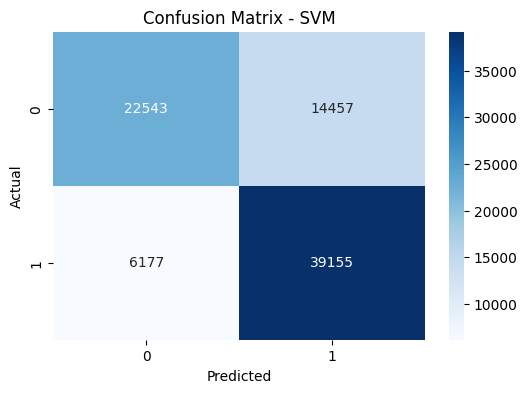

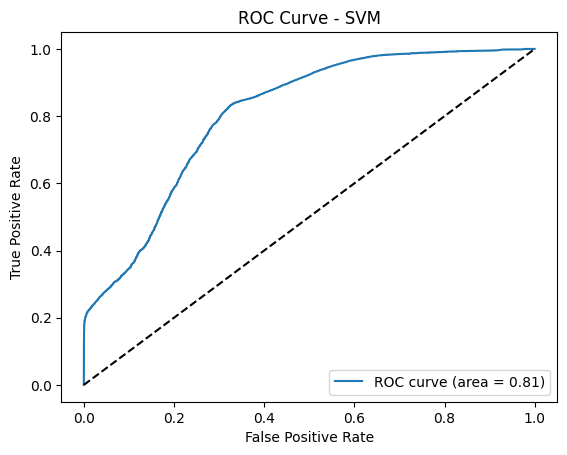

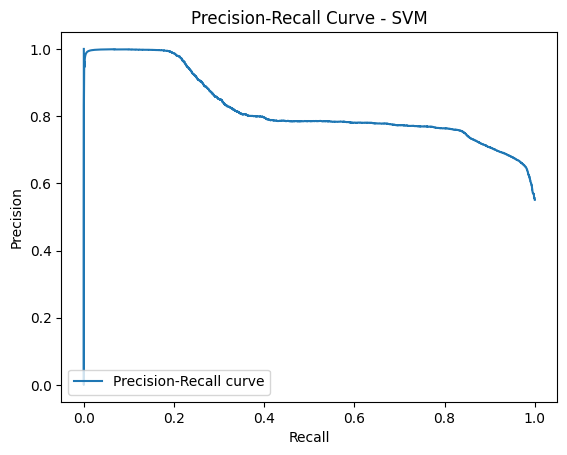

(0.7493805567701501,
 0.8637386393717462,
 0.7303402223382824,
 0.7914577943078913,
 0.8637386393717462,
 0.6092702702702703)

In [32]:
# Create a pipeline for scaling and training LinearSVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('svm', SVC(kernel="linear", class_weight="balanced", max_iter=10000))  # LinearSVC with balanced class weights
])

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(svm_pipeline, X_test, y_test, "SVM")

### Random Forest

=== Random Forest ===
Accuracy: 0.8620
Recall: 0.9859
Precision: 0.8066
F1-Score: 0.8873
Sensitivity: 0.9859
Specificity: 0.7103

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82     37000
           1       0.81      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.85     82332
weighted avg       0.88      0.86      0.86     82332



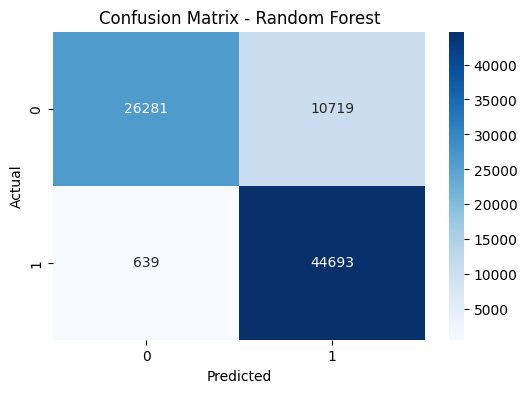

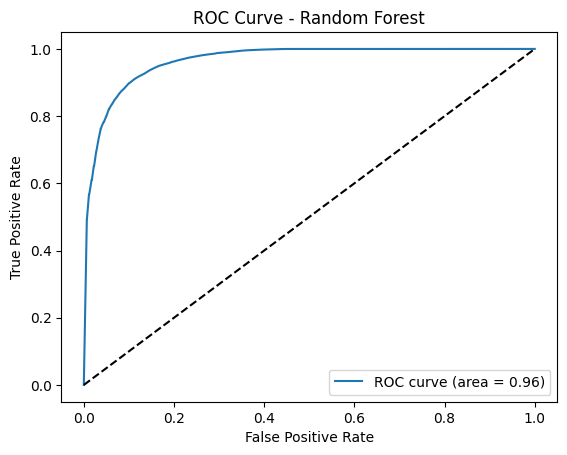

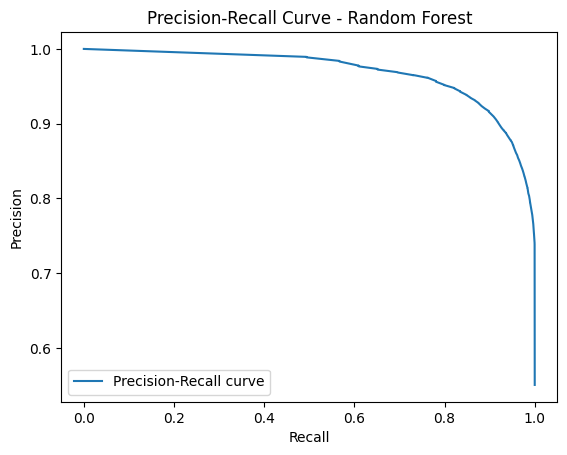

(0.8620463489287276,
 0.9859039971763875,
 0.8065581462499097,
 0.8872587945684111,
 0.9859039971763875,
 0.7102972972972973)

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=27)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

### XGBoost

=== XGBoost ===
Accuracy: 0.8957
Recall: 0.9597
Precision: 0.8655
F1-Score: 0.9102
Sensitivity: 0.9597
Specificity: 0.8172

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     37000
           1       0.87      0.96      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.90      0.89      0.89     82332
weighted avg       0.90      0.90      0.89     82332



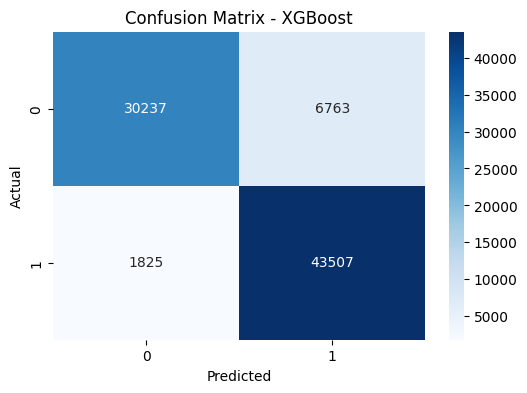

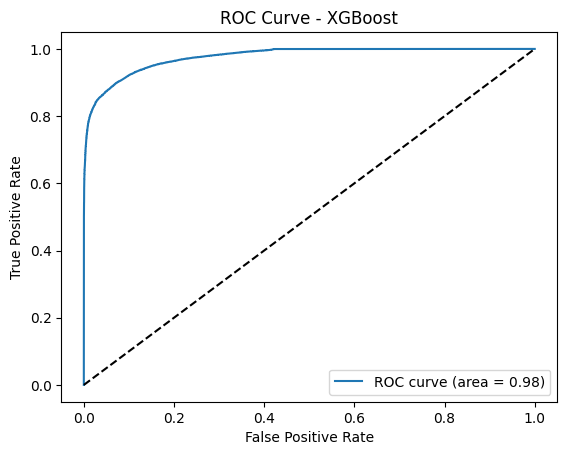

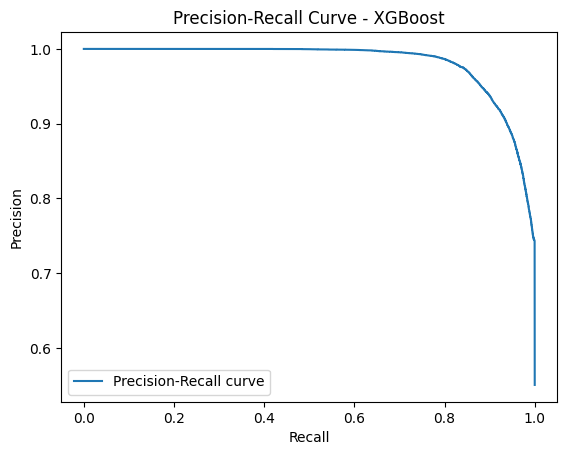

(0.8956906184715542,
 0.9597414629842054,
 0.865466481002586,
 0.9101692433212695,
 0.9597414629842054,
 0.8172162162162162)

In [34]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=27)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

### Neural Network

Epoch 1/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 712us/step - accuracy: 0.6634 - auc_6: 0.7696 - loss: 0.0468 - precision_6: 0.8656 - recall_6: 0.5256 - val_accuracy: 0.8776 - val_auc_6: 0.0000e+00 - val_loss: 0.0194 - val_precision_6: 1.0000 - val_recall_6: 0.8776
Epoch 2/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 668us/step - accuracy: 0.7046 - auc_6: 0.8548 - loss: 0.0342 - precision_6: 0.9110 - recall_6: 0.5619 - val_accuracy: 0.8641 - val_auc_6: 0.0000e+00 - val_loss: 0.0239 - val_precision_6: 1.0000 - val_recall_6: 0.8641
Epoch 3/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - accuracy: 0.7145 - auc_6: 0.8725 - loss: 0.0322 - precision_6: 0.9132 - recall_6: 0.5811 - val_accuracy: 0.8400 - val_auc_6: 0.0000e+00 - val_loss: 0.0183 - val_precision_6: 1.0000 - val_recall_6: 0.8400
Epoch 4/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 665us/step - accuracy: 0.7145 - auc_6: 0.8797 - loss: 0.0315 - precision_6: 0.9131 - recall_6: 0.5799 - val_accuracy: 0.8789 - val_auc_6: 0.0000e+00 - val_loss: 0.01

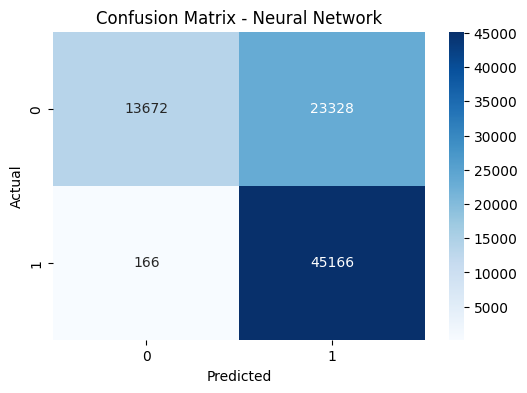

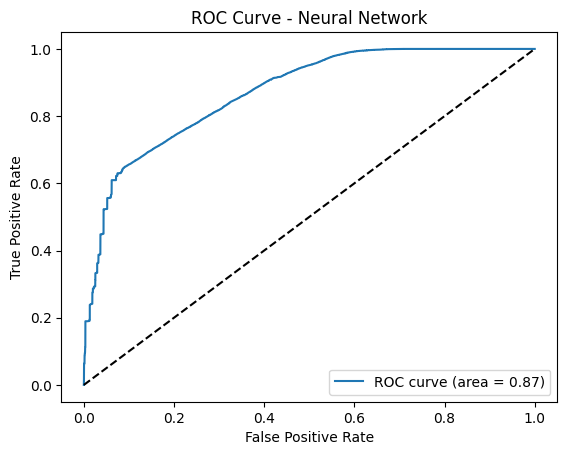

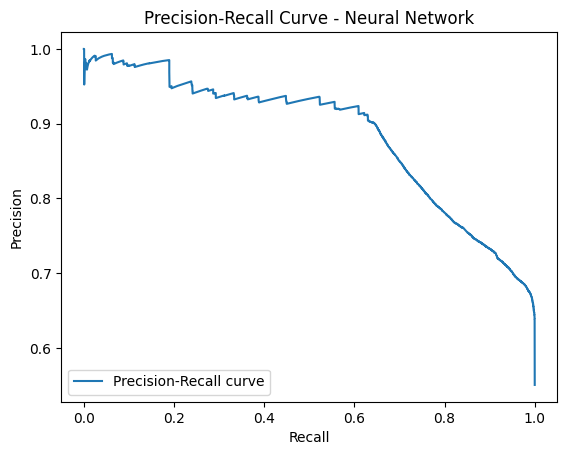

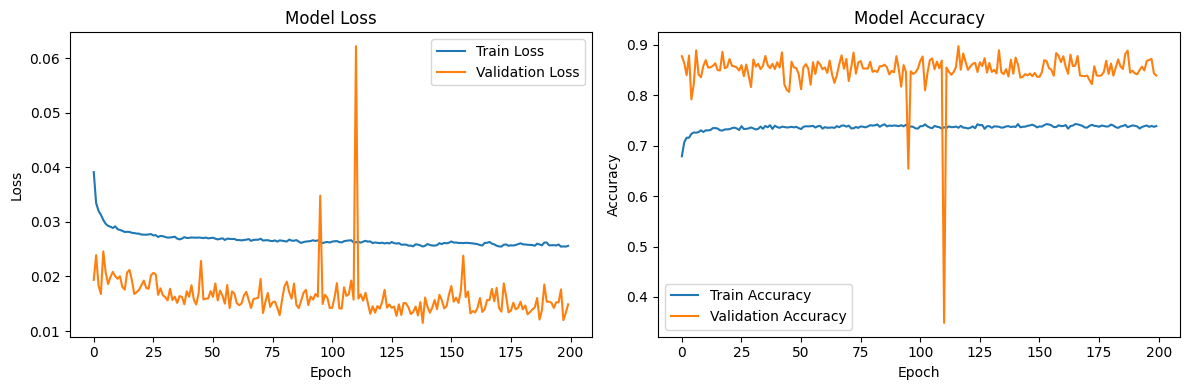

In [48]:
n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

tf_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),  # Increase first layer size
    BatchNormalization(),  # Add batch normalization
    Dropout(0.3),  # Add dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

history = tf_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,  
    validation_split=0.2,
    class_weight=class_weight,
    verbose=1
)

evaluate_model(tf_model, X_test, y_test, "Neural Network")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()